In [15]:
import pandas as pd
import numpy as np

In [16]:
# 0. 데이터 불러오기
file_path = r"C:\Users\JEONGHEE\Desktop\당뇨병플젝\dm_predic_hexa.csv"
df = pd.read_csv(file_path)

In [17]:
#기본 전체 행열 수수
df.head()
df.shape

(173357, 44)

In [18]:
columns_to_drop = [
    'DS1_SLPHR', 'DS1_SLPMIN', 'DS1_GTUPMHR', 'DS1_GTUPMMIN',
    'DS1_SLPDUHR', 'DS1_SLPDUMIN', 'DS1_HEIGHT', 'DS1_WEIGHT','DS1_CELL','DS1_SLEEP','DS1_MIN', 'DS1_LBM','DS1_PROTEIN'
]

# 1. 해당 열들 기준으로 결측치가 있는 행 먼저 제거
df.dropna(subset=columns_to_drop, inplace=True)

# 2. 그런 다음 열도 제거
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [19]:
df.head()
df.shape

(173357, 31)

## [[당뇨 과거력 있는 사람 제외하기]]

In [20]:
# 1. 당뇨 과거력 있는 사람 제외 (DS1_DM == 2)
df = df[df['DS1_DM'] == 1]

In [21]:
df.shape

(161148, 31)

In [22]:
summary = pd.DataFrame({
    '전체값 개수': df.count(),
    '66666 개수': (df == 66666).sum(),
    '99999 개수': (df == 99999).sum()
})

summary

,전체값 개수,66666 개수,99999 개수
DS1_ID,161148,0,0
DS1_SEX,161148,0,0
DS1_AGE,161148,0,0
DS1_HTN,161148,0,15
DS1_DM,161148,0,0
DS1_FDM,161148,0,873
DS1_EDU,161148,0,2473
DS1_MARRY,161148,7765,772
DS1_INCOME,161148,7765,18899
DS1_SMOKE,161148,78300,733


## [[특정 변수를 제외한 나머지 99999 값을 가진 모든 행 제거하기]]

In [23]:
# 2. 예외 변수 리스트
exclude_columns = ['DS1_MARRY', 'DS1_INCOME', 'DS1_SMOKE', 'DS1_SMOKE_100', 'DS1_HBA1C']

# 3. 제외할 컬럼을 뺀 나머지 컬럼에서 99999 값을 가진 행 제거
cols_to_check = [col for col in df.columns if col not in exclude_columns]

# 4. 조건에 맞는 행 필터링 (99999가 하나라도 있으면 제거)
condition = ~(df[cols_to_check] == 99999).any(axis=1)

# 5. 필터링 적용
df_cleaned = df[condition].copy()

In [24]:
# 제거 전/후 행 수 비교
original_shape = df.shape
cleaned_shape = df_cleaned.shape

print("제거 전 행 수:", original_shape[0])
print("제거 후 행 수:", cleaned_shape[0])
print("제거된 행 수:", original_shape[0] - cleaned_shape[0])

제거 전 행 수: 161148
제거 후 행 수: 124464
제거된 행 수: 36684


## [[smoke 변수 처리] 

In [70]:
##### smoke는 초반에는 400개비 기준으로 했다 중간부터는 100개 기준으로 자료 수집 함 -> smoke 데이터 새롭게 생성

In [29]:
def merge_smoke_with_flag(row):
    v1, v2 = row['DS1_SMOKE'], row['DS1_SMOKE_100']

    # 둘 다 이상치 → 결측
    if v1 in [66666, 99999] and v2 in [66666, 99999]:
        return pd.Series([np.nan, 'both_missing'])

    # DS1_SMOKE만 정상
    elif v1 not in [66666, 99999] and v2 in [66666, 99999]:
        return pd.Series([v1, 'from_SMOKE'])

    # DS1_SMOKE_100만 정상
    elif v1 in [66666, 99999] and v2 not in [66666, 99999]:
        return pd.Series([v2, 'from_SMOKE_100'])

    # 둘 다 정상
    else:
        # 혹시 다르면 플래그 다르게 줘도 됨
        if v1 == v2:
            return pd.Series([v1, 'both_same'])
        else:
            return pd.Series([v1, 'both_valid_diff'])

# 적용
df_cleaned[['SMOKE_MERGED', 'SMOKE_SOURCE']] = df_cleaned.apply(merge_smoke_with_flag, axis=1)


In [30]:
# 소스별 분포 확인
df_cleaned['SMOKE_SOURCE'].value_counts()

SMOKE_SOURCE
from_SMOKE_100    65553
from_SMOKE        58685
Name: count, dtype: int64

In [31]:
# SMOKE_MERGED가 NaN인 행 제거
df_cleaned = df_cleaned[df_cleaned['SMOKE_MERGED'].notna()].copy()

In [32]:
summary = pd.DataFrame({
    '전체값 개수': df_cleaned.count(),
    '66666 개수': (df_cleaned == 66666).sum(),
    '99999 개수': (df_cleaned == 99999).sum()
})

summary

,전체값 개수,66666 개수,99999 개수
DS1_ID,124238,0,0
DS1_SEX,124238,0,0
DS1_AGE,124238,0,0
DS1_HTN,124238,0,0
DS1_DM,124238,0,0
DS1_FDM,124238,0,0
DS1_EDU,124238,0,0
DS1_MARRY,124238,4412,119
DS1_INCOME,124238,4412,12890
DS1_SMOKE,124238,65553,0


In [33]:
df_cleaned.head(10)

,DS1_ID,DS1_SEX,DS1_AGE,DS1_HTN,DS1_DM,DS1_FDM,DS1_EDU,DS1_MARRY,DS1_INCOME,DS1_SMOKE,...,DS1_BMI,DS1_PBF,DS1_BODYFAT,DS1_MUSCLE,DS1_VISFAT,DS1_WHR,DS1_GLU0,DS1_HBA1C,SMOKE_MERGED,SMOKE_SOURCE
0,CT_EPI_000001,2,69,1,1,1,0,2,6,66666,...,25.16,35.0,18.5,31.4,2.4,0.90,76.0,5.8,1,from_SMOKE_100
1,CT_EPI_000002,2,62,1,1,1,3,6,4,66666,...,22.93,29.2,15.1,33.7,1.6,0.84,90.0,5.5,1,from_SMOKE_100
2,CT_EPI_000003,2,41,1,1,1,6,6,99999,2,...,25.30,33.3,19.6,36.0,2.4,0.84,92.0,66666.0,2,from_SMOKE
3,CT_EPI_000004,1,55,1,1,1,8,2,7,66666,...,22.17,21.6,14.2,47.6,2.0,0.84,104.0,5.6,2,from_SMOKE_100
5,CT_EPI_000006,1,56,2,1,1,7,2,7,66666,...,25.91,30.2,20.1,42.6,3.5,0.91,94.0,5.7,2,from_SMOKE_100
7,CT_EPI_000008,1,48,1,1,1,7,2,7,2,...,27.92,27.9,24.1,57.4,3.9,0.90,101.0,66666.0,2,from_SMOKE
8,CT_EPI_000009,2,52,1,1,1,4,2,8,66666,...,23.49,32.4,17.0,32.6,2.0,0.79,106.0,5.7,1,from_SMOKE_100
10,CT_EPI_000011,2,44,1,1,1,4,2,5,66666,...,20.24,26.3,13.0,33.7,1.3,0.83,91.0,5.0,1,from_SMOKE_100
12,CT_EPI_000013,1,56,2,1,1,4,2,4,3,...,24.59,18.6,14.0,56.9,1.9,0.89,106.0,66666.0,3,from_SMOKE
13,CT_EPI_000014,1,64,1,1,1,2,2,1,66666,...,23.55,23.7,16.0,47.6,2.3,0.90,90.0,5.5,1,from_SMOKE_100


In [34]:
# 1. 원래 변수들 삭제
df_cleaned.drop(columns=['DS1_SMOKE', 'DS1_SMOKE_100','SMOKE_SOURCE'], inplace=True)

# 2. SMOKE_MERGED를 DS1_SMOKE로 이름 변경
df_cleaned.rename(columns={'SMOKE_MERGED': 'DS1_SMOKE'}, inplace=True)

In [35]:
df_cleaned.head(10)

,DS1_ID,DS1_SEX,DS1_AGE,DS1_HTN,DS1_DM,DS1_FDM,DS1_EDU,DS1_MARRY,DS1_INCOME,DS1_DRINK,...,DS1_DBP,DS1_BMI,DS1_PBF,DS1_BODYFAT,DS1_MUSCLE,DS1_VISFAT,DS1_WHR,DS1_GLU0,DS1_HBA1C,DS1_SMOKE
0,CT_EPI_000001,2,69,1,1,1,0,2,6,1,...,80.0,25.16,35.0,18.5,31.4,2.4,0.90,76.0,5.8,1
1,CT_EPI_000002,2,62,1,1,1,3,6,4,1,...,90.0,22.93,29.2,15.1,33.7,1.6,0.84,90.0,5.5,1
2,CT_EPI_000003,2,41,1,1,1,6,6,99999,3,...,70.0,25.30,33.3,19.6,36.0,2.4,0.84,92.0,66666.0,2
3,CT_EPI_000004,1,55,1,1,1,8,2,7,3,...,80.0,22.17,21.6,14.2,47.6,2.0,0.84,104.0,5.6,2
5,CT_EPI_000006,1,56,2,1,1,7,2,7,2,...,60.0,25.91,30.2,20.1,42.6,3.5,0.91,94.0,5.7,2
7,CT_EPI_000008,1,48,1,1,1,7,2,7,3,...,70.0,27.92,27.9,24.1,57.4,3.9,0.90,101.0,66666.0,2
8,CT_EPI_000009,2,52,1,1,1,4,2,8,3,...,78.0,23.49,32.4,17.0,32.6,2.0,0.79,106.0,5.7,1
10,CT_EPI_000011,2,44,1,1,1,4,2,5,1,...,65.0,20.24,26.3,13.0,33.7,1.3,0.83,91.0,5.0,1
12,CT_EPI_000013,1,56,2,1,1,4,2,4,3,...,88.0,24.59,18.6,14.0,56.9,1.9,0.89,106.0,66666.0,3
13,CT_EPI_000014,1,64,1,1,1,2,2,1,1,...,67.5,23.55,23.7,16.0,47.6,2.3,0.90,90.0,5.5,1


In [36]:
df_cleaned.shape

(124238, 30)

## [[income과 marry의 66666 / 99999 처리 과정]]

In [37]:
summary = pd.DataFrame({
    '전체값 개수': df_cleaned.count(),
    '66666 개수': (df_cleaned == 66666).sum(),
    '99999 개수': (df_cleaned == 99999).sum()
})

summary

,전체값 개수,66666 개수,99999 개수
DS1_ID,124238,0,0
DS1_SEX,124238,0,0
DS1_AGE,124238,0,0
DS1_HTN,124238,0,0
DS1_DM,124238,0,0
DS1_FDM,124238,0,0
DS1_EDU,124238,0,0
DS1_MARRY,124238,4412,119
DS1_INCOME,124238,4412,12890
DS1_DRINK,124238,0,0


In [38]:
df_cleaned = df_cleaned[~df_cleaned['DS1_MARRY'].isin([66666, 99999])].copy()

In [39]:
summary = pd.DataFrame({
    '전체값 개수': df_cleaned.count(),
    '66666 개수': (df_cleaned == 66666).sum(),
    '99999 개수': (df_cleaned == 99999).sum()
})

summary

,전체값 개수,66666 개수,99999 개수
DS1_ID,119707,0,0
DS1_SEX,119707,0,0
DS1_AGE,119707,0,0
DS1_HTN,119707,0,0
DS1_DM,119707,0,0
DS1_FDM,119707,0,0
DS1_EDU,119707,0,0
DS1_MARRY,119707,0,0
DS1_INCOME,119707,0,12841
DS1_DRINK,119707,0,0


In [40]:
df_cleaned.shape

(119707, 30)

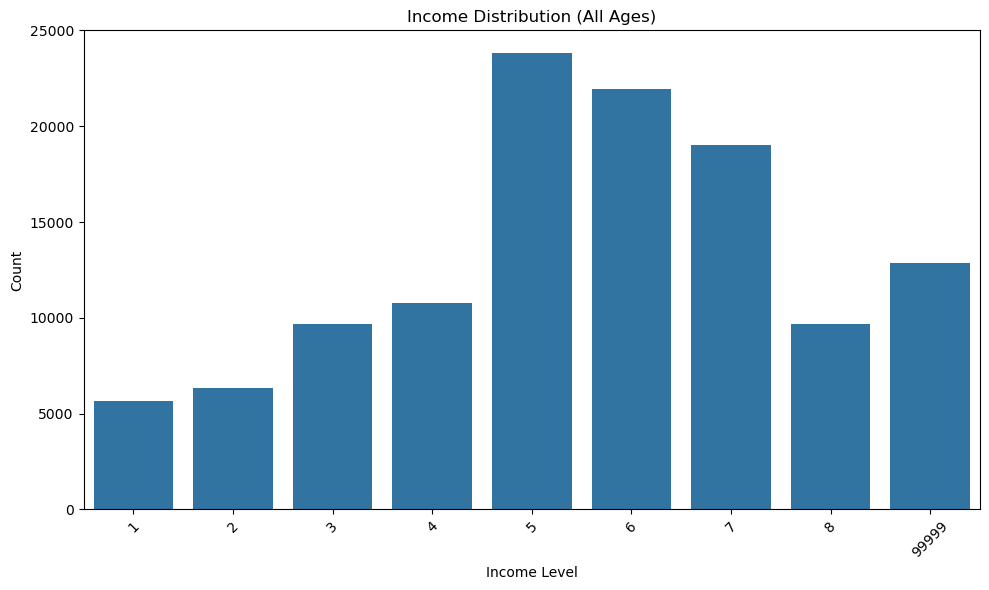

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 전체 소득 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='DS1_INCOME', data=df_cleaned, order=sorted(df_cleaned['DS1_INCOME'].unique()))
plt.title('Income Distribution (All Ages)')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

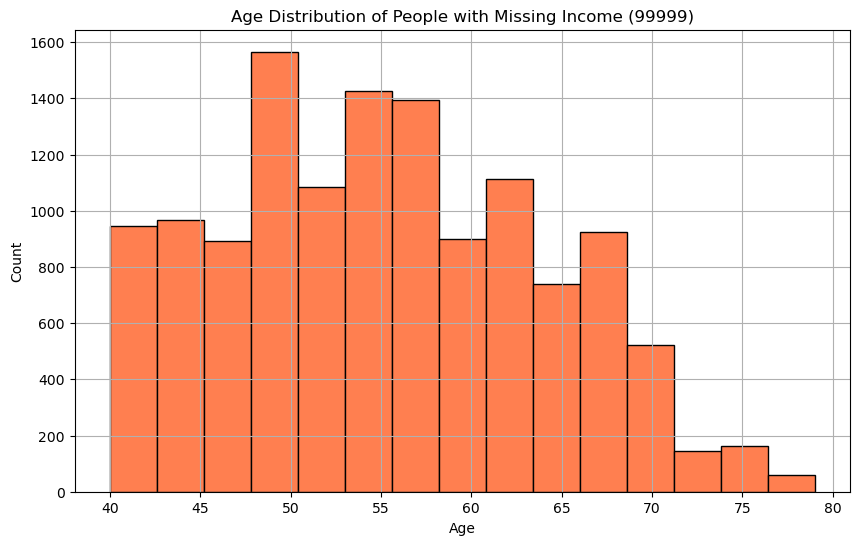

In [42]:
income_missing = df_cleaned[df_cleaned['DS1_INCOME'] == 99999]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(income_missing['DS1_AGE'], bins=15, color='coral', edgecolor='black')
plt.title('Age Distribution of People with Missing Income (99999)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [43]:
df_cleaned = df_cleaned[df_cleaned['DS1_INCOME'] != 99999].copy()

In [44]:
df_cleaned.shape

(106866, 30)

### -- 나이로 보는 수익 분포 -> 나이의 99999 비율이 10.4%로 큰 비율을 차지 하지 않아 제거하기로 결정

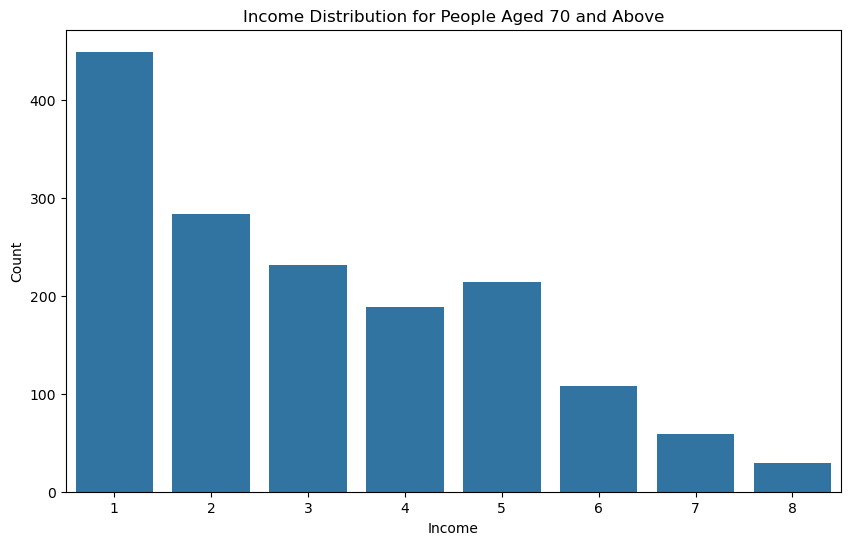

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# AGE가 70 이상인 사람들 필터링
age_70_plus = df_cleaned[df_cleaned['DS1_AGE'] >= 70]

# AGE가 70 이상인 사람들의 소득 수준 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='DS1_INCOME', data=age_70_plus)
plt.title('Income Distribution for People Aged 70 and Above')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

## [[결과변수 만들기]]

In [46]:
def get_dm_target(row):
    glu = row['DS1_GLU0']
    hba1c = row['DS1_HBA1C']
    
    # 이상치면 판단 보류 (결측)
    if glu in [66666, 99999] and hba1c in [66666, 99999]:
        return np.nan
    
    # 혈당만 정상일 경우
    if glu not in [66666, 99999] and glu >= 126:
        return 1
    
    # HbA1c만 정상일 경우
    if hba1c not in [66666, 99999] and hba1c >= 6.5:
        return 1
    
    return 0

# 적용
df_cleaned['DM_TARGET'] = df_cleaned.apply(get_dm_target, axis=1)

In [47]:
df_cleaned['DM_TARGET'].value_counts()

DM_TARGET
0    103582
1      3284
Name: count, dtype: int64

In [48]:
# 개수와 비율을 함께 보기
target_counts = df_cleaned['DM_TARGET'].value_counts()
target_ratio = df_cleaned['DM_TARGET'].value_counts(normalize=True) * 100

# 결과 합치기
dm_summary = pd.DataFrame({
    'Count': target_counts,
    'Percent (%)': target_ratio.round(2)
})

print(dm_summary)

            Count  Percent (%)
DM_TARGET                     
0          103582        96.93
1            3284         3.07


## [[수입, 교육수준, 결혼 여부 , 흡연 재범주화 진행]]

In [49]:
#1.소득수준 (1~4/5~6/7~8)
# DS1_INCOME을 1~4는 1, 5~6은 2, 7~8은 3으로 재범주화
df_cleaned['DS1_INCOME_RE'] = df_cleaned['DS1_INCOME'].replace({1: 1, 2: 1, 3: 1, 4: 1,
                                                   5: 2, 6: 2,
                                                   7: 3, 8: 3})
# 2.교육수준 (중학교 졸업 0~3은 1, 고등학교 졸업 4은 2,그 이상 5~8은 3)
# DS1_EDU를 재범주화
df_cleaned['DS1_EDU_RE'] = df_cleaned['DS1_EDU'].replace({0: 1, 1: 1, 2: 1, 3: 1,  # 0~3은 1
                                              4: 2,                      # 4는 2
                                              5: 3, 6: 3, 7: 3, 8: 3})  # 5~8은 3
# 3.결혼여부(기혼과 나머지)
# DS1_MARRY_RE를 기혼(2)은 1로, 그 외는 0으로 재범주화
df_cleaned['DS1_MARRY_RE'] = df_cleaned['DS1_MARRY'].apply(lambda x: 1 if x == 2 else 0)

In [50]:
def convert_exerfq(val):
    if val == 1:
        return 1.5   # 주1~2회
    elif val == 2:
        return 3.5   # 주3~4회
    elif val == 3:
        return 5.5   # 주5~6회
    elif val == 4:
        return 7     # 매일
    else:
        return 0  # 결측 처리
# 운동 빈도를 숫자로 변환
df_cleaned['운동횟수'] = df_cleaned['DS1_EXERFQ'].apply(convert_exerfq)
# 총 운동시간 계산 = 주당 횟수 × 1회 운동 시간
df_cleaned['total_exer'] = ( df_cleaned['운동횟수'] * df_cleaned['DS1_EXERDU'] ) /60

In [51]:
df_cleaned.shape

(106866, 36)

In [52]:
df_cleaned.head(10)

,DS1_ID,DS1_SEX,DS1_AGE,DS1_HTN,DS1_DM,DS1_FDM,DS1_EDU,DS1_MARRY,DS1_INCOME,DS1_DRINK,...,DS1_WHR,DS1_GLU0,DS1_HBA1C,DS1_SMOKE,DM_TARGET,DS1_INCOME_RE,DS1_EDU_RE,DS1_MARRY_RE,운동횟수,total_exer
0,CT_EPI_000001,2,69,1,1,1,0,2,6,1,...,0.90,76.0,5.8,1,0,2,1,1,0.0,0.00
1,CT_EPI_000002,2,62,1,1,1,3,6,4,1,...,0.84,90.0,5.5,1,0,1,1,0,1.5,3.00
3,CT_EPI_000004,1,55,1,1,1,8,2,7,3,...,0.84,104.0,5.6,2,0,3,3,1,0.0,0.00
5,CT_EPI_000006,1,56,2,1,1,7,2,7,2,...,0.91,94.0,5.7,2,0,3,3,1,1.5,1.50
7,CT_EPI_000008,1,48,1,1,1,7,2,7,3,...,0.90,101.0,66666.0,2,0,3,3,1,1.5,0.75
8,CT_EPI_000009,2,52,1,1,1,4,2,8,3,...,0.79,106.0,5.7,1,0,3,2,1,0.0,0.00
10,CT_EPI_000011,2,44,1,1,1,4,2,5,1,...,0.83,91.0,5.0,1,0,2,2,1,0.0,0.00
12,CT_EPI_000013,1,56,2,1,1,4,2,4,3,...,0.89,106.0,66666.0,3,0,1,2,1,5.5,5.50
13,CT_EPI_000014,1,64,1,1,1,2,2,1,1,...,0.90,90.0,5.5,1,0,1,1,1,0.0,0.00
14,CT_EPI_000015,2,59,1,1,1,7,5,4,1,...,0.82,78.0,5.9,1,0,1,3,0,0.0,0.00


In [53]:
# 흡연자 이진 변수 생성
df_cleaned['SMOKE_YN'] = df_cleaned['DS1_SMOKE'].apply(lambda x: 1 if x in [2, 3] else 0)

# 음주자 이진 변수 생성
df_cleaned['DRINK_YN'] = df_cleaned['DS1_DRINK'].apply(lambda x: 1 if x in [2, 3] else 0)

In [54]:
df_cleaned.head(10)

,DS1_ID,DS1_SEX,DS1_AGE,DS1_HTN,DS1_DM,DS1_FDM,DS1_EDU,DS1_MARRY,DS1_INCOME,DS1_DRINK,...,DS1_HBA1C,DS1_SMOKE,DM_TARGET,DS1_INCOME_RE,DS1_EDU_RE,DS1_MARRY_RE,운동횟수,total_exer,SMOKE_YN,DRINK_YN
0,CT_EPI_000001,2,69,1,1,1,0,2,6,1,...,5.8,1,0,2,1,1,0.0,0.00,0,0
1,CT_EPI_000002,2,62,1,1,1,3,6,4,1,...,5.5,1,0,1,1,0,1.5,3.00,0,0
3,CT_EPI_000004,1,55,1,1,1,8,2,7,3,...,5.6,2,0,3,3,1,0.0,0.00,1,1
5,CT_EPI_000006,1,56,2,1,1,7,2,7,2,...,5.7,2,0,3,3,1,1.5,1.50,1,1
7,CT_EPI_000008,1,48,1,1,1,7,2,7,3,...,66666.0,2,0,3,3,1,1.5,0.75,1,1
8,CT_EPI_000009,2,52,1,1,1,4,2,8,3,...,5.7,1,0,3,2,1,0.0,0.00,0,1
10,CT_EPI_000011,2,44,1,1,1,4,2,5,1,...,5.0,1,0,2,2,1,0.0,0.00,0,0
12,CT_EPI_000013,1,56,2,1,1,4,2,4,3,...,66666.0,3,0,1,2,1,5.5,5.50,1,1
13,CT_EPI_000014,1,64,1,1,1,2,2,1,1,...,5.5,1,0,1,1,1,0.0,0.00,0,0
14,CT_EPI_000015,2,59,1,1,1,7,5,4,1,...,5.9,1,0,1,3,0,0.0,0.00,0,0


In [55]:
df_cleaned.columns

Index(['DS1_ID', 'DS1_SEX', 'DS1_AGE', 'DS1_HTN', 'DS1_DM', 'DS1_FDM',
       'DS1_EDU', 'DS1_MARRY', 'DS1_INCOME', 'DS1_DRINK', 'DS1_EXER',
       'DS1_EXERFQ', 'DS1_EXERDU', 'DS1_WALK', 'DS1_WALKFQ', 'DS1_WALKT',
       'DS1_WAIST', 'DS1_HIP', 'DS1_PULSE', 'DS1_SBP', 'DS1_DBP', 'DS1_BMI',
       'DS1_PBF', 'DS1_BODYFAT', 'DS1_MUSCLE', 'DS1_VISFAT', 'DS1_WHR',
       'DS1_GLU0', 'DS1_HBA1C', 'DS1_SMOKE', 'DM_TARGET', 'DS1_INCOME_RE',
       'DS1_EDU_RE', 'DS1_MARRY_RE', '운동횟수', 'total_exer', 'SMOKE_YN',
       'DRINK_YN'],
      dtype='object')

In [56]:
df_cleaned.shape

(106866, 38)

In [57]:
smoke_counts = df_cleaned['SMOKE_YN'].value_counts()
smoke_counts 

SMOKE_YN
0    77639
1    29227
Name: count, dtype: int64

## [[여자/남자 성별 분리해서 파일 생성]]

In [58]:
df_cleaned['SEX_LABEL'] = df_cleaned['DS1_SEX'].map({1: '1', 2: '2'})

In [59]:
df_cleaned['SEX_LABEL'].value_counts()

SEX_LABEL
2    70308
1    36558
Name: count, dtype: int64

In [60]:
# 성별-당뇨 여부 교차표
pd.crosstab(df_cleaned['SEX_LABEL'], df_cleaned['DM_TARGET'], margins=True)

DM_TARGET,0,1,All
SEX_LABEL,,,
1,34951,1607,36558
2,68631,1677,70308
All,103582,3284,106866


In [61]:
df_cleaned.columns

Index(['DS1_ID', 'DS1_SEX', 'DS1_AGE', 'DS1_HTN', 'DS1_DM', 'DS1_FDM',
       'DS1_EDU', 'DS1_MARRY', 'DS1_INCOME', 'DS1_DRINK', 'DS1_EXER',
       'DS1_EXERFQ', 'DS1_EXERDU', 'DS1_WALK', 'DS1_WALKFQ', 'DS1_WALKT',
       'DS1_WAIST', 'DS1_HIP', 'DS1_PULSE', 'DS1_SBP', 'DS1_DBP', 'DS1_BMI',
       'DS1_PBF', 'DS1_BODYFAT', 'DS1_MUSCLE', 'DS1_VISFAT', 'DS1_WHR',
       'DS1_GLU0', 'DS1_HBA1C', 'DS1_SMOKE', 'DM_TARGET', 'DS1_INCOME_RE',
       'DS1_EDU_RE', 'DS1_MARRY_RE', '운동횟수', 'total_exer', 'SMOKE_YN',
       'DRINK_YN', 'SEX_LABEL'],
      dtype='object')

In [62]:
columns_to_drop = [
    'DS1_DM', 'DS1_EDU', 'DS1_MARRY', 'DS1_INCOME',
    'DS1_DRINK', 'DS1_EXERFQ', 'DS1_EXERDU',
    '운동횟수', 'SEX_LABEL','DS1_SMOKE'
]

df_cleaned.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [63]:
df_cleaned.shape

(106866, 29)

In [64]:
df_cleaned.columns

Index(['DS1_ID', 'DS1_SEX', 'DS1_AGE', 'DS1_HTN', 'DS1_FDM', 'DS1_EXER',
       'DS1_WALK', 'DS1_WALKFQ', 'DS1_WALKT', 'DS1_WAIST', 'DS1_HIP',
       'DS1_PULSE', 'DS1_SBP', 'DS1_DBP', 'DS1_BMI', 'DS1_PBF', 'DS1_BODYFAT',
       'DS1_MUSCLE', 'DS1_VISFAT', 'DS1_WHR', 'DS1_GLU0', 'DS1_HBA1C',
       'DM_TARGET', 'DS1_INCOME_RE', 'DS1_EDU_RE', 'DS1_MARRY_RE',
       'total_exer', 'SMOKE_YN', 'DRINK_YN'],
      dtype='object')

## [[연속형 변수와 범주형 변수 분리하기]]

In [69]:
def classify_variable(series, threshold=10):
    if pd.api.types.is_numeric_dtype(series):
        if series.nunique() <= threshold:
            return 'categorical'
        else:
            return 'continuous'
    else:
        return 'categorical'

# DM_TARGET 같은 결과 변수 제외하고 분석
var_types = {col: classify_variable(df_cleaned[col]) for col in df_cleaned.columns}

# 변수 목록 구분
categorical_vars = [col for col, vtype in var_types.items() if vtype == 'categorical']
continuous_vars = [col for col, vtype in var_types.items() if vtype == 'continuous']

# 확인
print("범주형 변수:")
print(categorical_vars)

print("\n연속형 변수:")
print(continuous_vars)

범주형 변수:
['DS1_ID', 'DS1_SEX', 'DS1_HTN', 'DS1_FDM', 'DS1_EXER', 'DS1_WALK', 'DM_TARGET', 'DS1_INCOME_RE', 'DS1_EDU_RE', 'DS1_MARRY_RE', 'SMOKE_YN', 'DRINK_YN']

연속형 변수:
['DS1_AGE', 'DS1_WALKFQ', 'DS1_WALKT', 'DS1_WAIST', 'DS1_HIP', 'DS1_PULSE', 'DS1_SBP', 'DS1_DBP', 'DS1_BMI', 'DS1_PBF', 'DS1_BODYFAT', 'DS1_MUSCLE', 'DS1_VISFAT', 'DS1_WHR', 'DS1_GLU0', 'DS1_HBA1C', 'total_exer']
